### Recap from previous Lab

* We "closed the loop" on our first MultiLayer Perceptron (MLP), exploring how the training routine is implemented in PyTorch (PT):

    * we saw how to use built-in loss functions in PT and we learned how to construct custom losses based upon tensor methods
    * moreover, we also saw how to use vanilla Stochastic Gradient Descent (SGD) in conjunction with backpropagation to enable the parameters updating in our MLP

### Agenda for today

* The main topic of our lecture is **regularization**
* First of all, though, we will implement a framework for monitoring the parameters during training (the so called *trajectory*), a simple research exercize
* On to regularization, we will see how to utilize various way to infuse regularization into our MLP training, still with an eye on the trajectory:

  * L2 regularization (aka *weight decay*)
  * dropout
  * regularization layers
  

### Examining parameters mid-training – the trajectory

We already covered how to save the "snapshot" of the parameters via the `state_dict` during the previous Lab.
We can use the same method to recover the trajectory during our training.

In [1]:
import torch
import os
from torch import nn
from matplotlib import pyplot as plt


from scripts import mnist
from scripts.train_utils import accuracy, AverageMeter

Let us quickly recover the stuff we implemented during Lab 2

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()
        self.h1 = nn.Linear(28*28, 16)
        self.h2 = nn.Linear(16, 32)
        self.h3 = nn.Linear(32, 24)
        self.out = nn.Linear(24, 10)
    
    def forward(self, X, activ_hidden=nn.functional.relu):
        out = self.flat(X)
        out = activ_hidden(self.h1(out))
        out = activ_hidden(self.h2(out))
        out = activ_hidden(self.h3(out))
        out = self.out(out)
        return out

In [64]:
def train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, trajectory): # note: I've added a generic performance to replace accuracy
    for X, y in dataloader:
        # 1. reset the gradients previously accumulated by the optimizer
        #    this will avoid re-using gradients from previous loops
        optimizer.zero_grad() 
        # 2. get the predictions from the current state of the model
        #    this is the forward pass
        y_hat = model(X)
        # 3. calculate the loss on the current mini-batch
        loss = loss_fn(y_hat, y)
        # 4. execute the backward pass given the current loss
        loss.backward()
        # 5. update the value of the params
        optimizer.step()
        # 6. calculate the accuracy for this mini-batch
        acc = performance(y_hat, y)
        # 7. update the loss and accuracy AverageMeter
        loss_meter.update(val=loss.item(), n=X.shape[0])
        performance_meter.update(val=acc, n=X.shape[0])

        if trajectory is not None:
            trajectory.append({k: v.clone() for k, v in model.state_dict().items()})

def train_model(model, dataloader, loss_fn, optimizer, num_epochs, checkpoint_loc=None, checkpoint_name="checkpoint.pt", performance=accuracy, trajectory=None): # note: I've added a generic performance to replace accuracy and an object where to store the trajectory

    # create the folder for the checkpoints (if it's not None)
    if checkpoint_loc is not None:
        os.makedirs(checkpoint_loc, exist_ok=True)
    
    model.train()

    # epoch loop
    for epoch in range(num_epochs):
        loss_meter = AverageMeter()
        performance_meter = AverageMeter()

        train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, trajectory)

        print(f"Epoch {epoch+1} completed. Loss - total: {loss_meter.sum} - average: {loss_meter.avg}; Performance: {performance_meter.avg}")

        # produce checkpoint dictionary -- but only if the name and folder of the checkpoint are not None
        if checkpoint_name is not None and checkpoint_loc is not None:
            checkpoint_dict = {
                "parameters": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch
            }
            torch.save(checkpoint_dict, os.path.join(checkpoint_loc, checkpoint_name))
        
        # append the current params to the trajectory
        # if trajectory is not None:
        #     current_state_dict = {k: v.clone() for k, v in model.state_dict().items()} # comment on this line - why that and not `model.state_dict()`
        #     trajectory.append(current_state_dict)
    
    return loss_meter.sum, performance_meter.avg, trajectory

def test_model(model, dataloader, performance=accuracy, loss_fn=None):
    # create an AverageMeter for the loss if passed
    if loss_fn is not None:
        loss_meter = AverageMeter()
    
    performance_meter = AverageMeter()

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            y_hat = model(X)
            loss = loss_fn(y_hat, y) if loss_fn is not None else None
            acc = performance(y_hat, y)
            if loss_fn is not None:
                loss_meter.update(loss.item(), X.shape[0])
            performance_meter.update(acc, X.shape[0])
    # get final performances
    fin_loss = loss_meter.sum if loss_fn is not None else None
    fin_perf = performance_meter.avg
    print(f"TESTING - loss {fin_loss if fin_loss is not None else '--'} - performance {fin_perf}")
    return fin_loss, fin_perf

In [7]:
minibatch_size_train = 256
minibatch_size_test = 512

trainloader, testloader, trainset, testset = mnist.get_data(batch_size_train=minibatch_size_test, batch_size_test=minibatch_size_test)

In [8]:
learn_rate = 0.1
num_epochs = 5

model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)

trajectory = [model.state_dict()] # we want to store the trajectory at initialization as well

In [17]:
train_loss, train_acc, trajectory = train_model(model, trainloader, loss_fn, optimizer, num_epochs, trajectory=trajectory)

Epoch 1 completed. Loss - total: 85229.01518249512 - average: 1.4204835863749186; Performance: 0.5123666666348775
Epoch 2 completed. Loss - total: 24090.54340171814 - average: 0.40150905669530235; Performance: 0.8784666666666666
Epoch 3 completed. Loss - total: 18320.607746124268 - average: 0.30534346243540444; Performance: 0.90845
Epoch 4 completed. Loss - total: 15872.976515293121 - average: 0.2645496085882187; Performance: 0.9211666666666667
Epoch 5 completed. Loss - total: 14254.74482536316 - average: 0.23757908042271933; Performance: 0.9290666666984558


Let us examine the trajectory to see how parameters are encoded

In [18]:
print("--Trajectory--")
print("Length:", len(trajectory))
print("Name of parameters:", list(trajectory[0].keys()))
print("Shapes of parameters tensors")
# we loop through a state_dict as a dictionary:
for i, (param_name, params) in enumerate(trajectory[0].items()):
    print(f"  {i+1}:", param_name, "\t", params.shape)

--Trajectory--
Length: 591
Name of parameters: ['h1.weight', 'h1.bias', 'h2.weight', 'h2.bias', 'h3.weight', 'h3.bias', 'out.weight', 'out.bias']
Shapes of parameters tensors
  1: h1.weight 	 torch.Size([16, 784])
  2: h1.bias 	 torch.Size([16])
  3: h2.weight 	 torch.Size([32, 16])
  4: h2.bias 	 torch.Size([32])
  5: h3.weight 	 torch.Size([24, 32])
  6: h3.bias 	 torch.Size([24])
  7: out.weight 	 torch.Size([10, 24])
  8: out.bias 	 torch.Size([10])


As a first step towards examining the trajectory, we might wanna calculate the norm of the parameters.

First we may want to gather all of the parameters inside a single structure. We hence define a function which lets us do so

In [19]:
def flatten_parameters(state_dict):
    # this gives us the number of parameters per layer
    params_num_per_layer = [struct.numel() for struct in state_dict.values()]
    # by summing the list, we get the total no. of parameters
    params_num = sum(params_num_per_layer)
    # we create a tensor to host all of these parameters
    params_tensor = torch.empty([params_num])
    # we populate the tensor
    num_params_inserted = 0
    for struct in state_dict.values():
        params_tensor[num_params_inserted : num_params_inserted + struct.numel()] = struct.flatten()
        num_params_inserted += struct.numel()
    
    return params_tensor

We execute for each trajectory

In [42]:
trajectories_flattened = [flatten_parameters(t) for t in trajectory]

Now we can calculate the norms and plot them to try and find regularities or trends

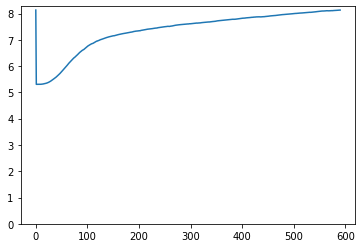

In [21]:
trajectories_norms = [f.norm() for f in trajectories_flattened]
plt.plot(trajectories_norms)
plt.ylim(0)
plt.show()

Similarly, we might want to monitor also the gradient. In PT, the gradient *after* a backward pass is executed can be find *attached* to the parameters, but not on the state_dicts (where gradients get *stripped* from the params instead).

We slightly modify our `train_epoch` function so that we can store the gradients as well.

In [ ]:
def train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, trajectory): # note: I've added a generic performance to replace accuracy
    for X, y in dataloader:
        # 1. reset the gradients previously accumulated by the optimizer
        #    this will avoid re-using gradients from previous loops
        optimizer.zero_grad() 
        # 2. get the predictions from the current state of the model
        #    this is the forward pass
        y_hat = model(X)
        # 3. calculate the loss on the current mini-batch
        loss = loss_fn(y_hat, y)
        # 4. execute the backward pass given the current loss
        loss.backward()
        # 5. update the value of the params
        optimizer.step()
        # 6. calculate the accuracy for this mini-batch
        acc = performance(y_hat, y)
        # 7. update the loss and accuracy AverageMeter
        loss_meter.update(val=loss.item(), n=X.shape[0])
        performance_meter.update(val=acc, n=X.shape[0])

        if trajectory is not None:
            trajectory[0].append({k:v.detach().clone() for k, v in model.named_parameters()})
            trajectory[1].append({k:v.grad for k,v in model.named_parameters()})

In [ ]:
model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)
trajectory = [[], []]
train_loss, train_acc, trajectory = train_model(model, trainloader, loss_fn, optimizer, num_epochs, trajectory=trajectory)

In [69]:
trajectory["grad"][1]

e-03,
           5.6265e-03,  8.0575e-03, -1.0731e-02, -2.8094e-03, -1.0691e-03,
           1.4429e-03, -8.9919e-04, -8.6979e-03, -2.0606e-02,  1.7061e-04,
          -1.2512e-02],
         [-4.5745e-02, -1.0151e-01, -4.0146e-02,  1.0908e-01, -7.6080e-02,
          -2.1610e-02, -1.3688e-01, -4.8557e-03, -2.9645e-02, -1.4635e-02,
          -2.1609e-02, -3.0284e-02,  2.1390e-02, -1.3596e-02, -4.0281e-02,
          -3.8887e-02],
         [ 1.2004e-02, -1.1182e-02, -1.7907e-04,  1.9186e-03, -5.1190e-03,
          -1.8160e-03, -1.9186e-02, -3.3815e-03, -2.4352e-04, -3.3133e-03,
          -3.8147e-04, -1.1240e-03, -5.8668e-03, -2.4902e-02, -1.4514e-02,
          -4.5875e-04],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [-4.8948e-02, -3.1135e-02, -2.8076e-03,  2.8403e-02, -2.0109e-02

In [54]:
trajectories_grad_flattened = [flatten_parameters(t["grad"]) for t in trajectory]

KeyError: 'grad'

In [51]:
trajectories_flattened[0].grad

<ipython-input-51-7403d567e7c1>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  trajectories_flattened[0].grad


In [50]:
trajectories_grad_norms = [f.grad.norm() for f in trajectories_flattened]

<ipython-input-50-b33fb5191f66>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  trajectories_grad_norms = [f.grad.norm() for f in trajectories_flattened]


AttributeError: 'NoneType' object has no attribute 'norm'

Comment on the trend we just saw

### Regularization

Regularization in DL comes in the form of different tools. We can have:

1. Penalty terms in loss functions (e.g. L1 and L2 norm regularization) which introduce bias in our parameters by actively reducing the magnitude of some weights:
    * L1 norm regularization is also called LASSO regularization
    * L2 norm regularization is also called Ridge regularization or **weight decay**
    * they were originally implemented in linear regression models as a way to infuse *inductive bias* in models originally thought to rely on the complete unbiasedness on training data
2. Normalization layers which normalize the incoming information s.t. their mean is zero and standard deviation one. It comes in different flavors:
    * batch normalization or batchnorm (the most common technique)
    * group normalization or groupnorm
    * there are more possibilities, for additional info on these, please check [this lecture by Aaron Defazio, NYU](https://atcold.github.io/pytorch-Deep-Learning/en/week05/05-2/)
3. Dropout, a technique [patented by Google](https://patents.google.com/patent/US9406017B2/en) which consists in randomly *dropping* some neurons from a given layer to prevent overfitting.
4. Early stopping, which we'll see later on during this Lab.

#### Weight decay or L2 norm/Ridge regularization

Weight Decay (WD) is a simple technique which *appends* a penalty term to the loss function equation. The term is based upon the L2 norm of the weights.

Given our original loss function $\mathcal{L}_0 (\hat{y}, y)$ and our parameter vector $\Theta$, our new loss will be:

$\mathcal{L}_0 (\hat{y}, y) + \lambda \cdot \vert\vert \Theta \vert\vert_2$

the parameter $\lambda$ (also called weight decay) controls the strenght of the regularization. $\lambda$ too high means that the model will not concentrate well enough on the original objective ($\mathcal{L}_0$), hence it will not perform well. Usually, good values form $\lambda$ fall into the interval $[5\cdot 10^{-4}, 1\cdot 10^{-4}]$.

In PT, instead of inserting our penalty term in the loss function, we specify the weight decay parameter in our optimizer:

In [13]:
weight_decay = 5e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate, weight_decay=weight_decay)

#### L1 norm regularization

L1 norm regularization is analogous to weight decay. The equation is:

$\mathcal{L}_0 (\hat{y}, y) + \lambda \cdot \vert\vert \Theta \vert\vert_1$

where $\vert\vert x \vert\vert_1 = \sum_{j=1}^d \vert x_j \vert$

unlike weight decay, to my knowledge PT does not provide a built-in for L1 reg. You need to define a custom loss function for this task (**homework**).

#### batchnorm

Batch Normalization operates in such a way that the mean and standard deviation of the incoming batches of data are approximately 0 and 1 respectively.

The ultimate goal of batchnorm is not to normalize each batch, but estimate one vector for mean (a running mean) and one for std (a running std) for the whole dataset and to normalize w.r.t. these. So, these become new parameters of the network. They are not adjusted via backprop but they get adjusted each time the layer *sees* another batch of data.

![](https://miro.medium.com/max/474/1*QQ2Q5rVBtLv7b3yGhO0flg.png)

*picture from [towardsdatascience.com](https://towardsdatascience.com/batch-normalisation-explained-5f4bd9de5feb)*

When the network is evaluated on test data, the running mean and std must not be adjusted, hence PT has implemented a "switch", which we saw during the previous Lab, to tell the network when to adjust and not adjust these two parameters. The switch is triggered via `model.train()` and `model.eval()` (or equivalently `model.train(False)`).

In PT, the batch normalization is found as a regular layer under within the `torch.nn` library

In [16]:
class MLP_BN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 16),
            nn.ReLU(),

            nn.BatchNorm1d(num_features=16), # we specify the dimensionality of the incoming data
            nn.Linear(16, 32),
            nn.ReLU(),

            nn.BatchNorm1d(num_features=32),
            nn.Linear(32, 24),
            nn.ReLU(),

            nn.BatchNorm1d(num_features=24),
            nn.Linear(24, 10)
        )


    def forward(self, X):
        return self.layers(X)

**Q** (for the most skilled students): why didn't we apply batchnorm for the first layer?

By peeking at the PT docs, we can see that actually the batchnorm layers have much more hyperparameters which we can play with if we wanted to:

![](img/bn_docs.jpg)

*from [PyTorch docs](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)*

In addition to what we say till now, there is still some debate in the DL community on whether batchnorm or other normalization techniques help optimization. The claims in the original paper [1](https://arxiv.org/abs/1502.03167) of "reducing internal covariate shift" was confuted in successive works such as [2](https://arxiv.org/abs/1805.11604.pdf), which claims that it "makes the optimization landscape significantly smoother". Another things to consider is that, since the data is distributed in a small intervall around 0, there's also a better numerical stability added.

#### Dropout

Dropout acts by removing (i.e. *zeroing-out*) a random subset of the neurons in a given layer for each forward pass.

It has one hyperparameter ($p$), which is the fraction of neurons to be dropped out.

During training, each time a layer with backprop produces an output, a fraction $p$ of that output gets discarded. This helps in such a way that co-dependence between neurons gets *forgotten* by the network. To say it in simple terms, it forces each neuron to be independent from the output of other neurons within the same layer.

For the same reason as in batchnorm, since dropout has to apply only during training, we must be careful in activating the switch `model.eval()` when testing our network.

In PT, we find Dropout as a module of `torch.nn`. Instead of placing if *before* the layer (as in batchnorm), we place it *after* the layer (the reason being, the layer produces an output, a portion $p$ of that output gets discarded).

In [ ]:
class MLP_BN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 16),
            nn.ReLU(),

            nn.BatchNorm1d(num_features=16),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Dropout(p=.2), # we add a dropout here. it's referred to the previous layer (with 32 neurons)

            nn.BatchNorm1d(num_features=32),
            nn.Linear(32, 24),
            nn.ReLU(),

            nn.BatchNorm1d(num_features=24),
            nn.Linear(24, 10)
        )


    def forward(self, X):
        return self.layers(X)

In [ ]:
**References**

[1](https://arxiv.org/abs/1502.03167) Ioffe, S., & Szegedy, C. (2015, June). Batch normalization: Accelerating deep network training by reducing internal covariate shift. In International conference on machine learning (pp. 448-456). PMLR.

[2](https://arxiv.org/abs/1805.11604.pdf) Santurkar, S., Tsipras, D., Ilyas, A., & Madry, A. (2018). How does batch normalization help optimization?. arXiv preprint arXiv:1805.11604.